In [98]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.impute import MissingIndicator
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVC, SVR
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, roc_curve, mean_absolute_error, mean_squared_error, r2_score, accuracy_score
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor

%matplotlib inline 

Датасет о путешествиях предоставляет детальную информацию о различных поездках, совершенных путешественниками, включая их пункты назначения, даты поездок, продолжительность путешествия в днях, демографические данные путешественников (имя, возраст, пол и национальность), а также тип и стоимость проживания и транспорта. Этот датасет можно использовать для получения информации о паттернах путешествий, предпочтениях и поведении различных типов путешественников. Он также может быть полезен для компаний, связанных с путешествиями, таких как туристические агентства, для создания целевых маркетинговых стратегий и туристических пакетов, соответствующих нуждам и предпочтениям различных путешественников.

1. Проведение разведочного анализа данных. Построение графиков, необходимых для понимания структуры данных. Анализ и заполнение пропусков в данных

In [99]:
data = pd.read_csv('Travel details dataset.csv' , sep=",")

# Преобразование дат в формат datetime
data['Start date'] = pd.to_datetime(data['Start date'])
data['End date'] = pd.to_datetime(data['End date'])

# Вычисление продолжительности поездки
data['Duration (days)'] = (data['End date'] - data['Start date']).dt.days

# Извлечение месяца и дня недели начала поездки
data['Start month'] = data['Start date'].dt.month
data['Start weekday'] = data['Start date'].dt.weekday

# Удаление столбцов с датами
data.drop(['Start date', 'End date','Traveler name'], axis=1, inplace=True)

data['Accommodation cost'] = data['Accommodation cost'].replace('[^\d.]', '', regex=True).astype(float)
data['Transportation cost'] = data['Transportation cost'].replace('[^\d.]', '', regex=True).astype(float)

# размер набора данных
data.shape


(139, 12)

In [100]:
# Первые 5 строк датасета
data.head()

,Trip ID,Destination,Duration (days),Traveler age,Traveler gender,Traveler nationality,Accommodation type,Accommodation cost,Transportation type,Transportation cost,Start month,Start weekday
0,1,"London, UK",7.0,35.0,Male,American,Hotel,1200.0,Flight,600.0,5.0,0.0
1,2,"Phuket, Thailand",5.0,28.0,Female,Canadian,Resort,800.0,Flight,500.0,6.0,3.0
2,3,"Bali, Indonesia",7.0,45.0,Male,Korean,Villa,1000.0,Flight,700.0,7.0,5.0
3,4,"New York, USA",14.0,29.0,Female,British,Hotel,2000.0,Flight,1000.0,8.0,1.0
4,5,"Tokyo, Japan",7.0,26.0,Female,Vietnamese,Airbnb,700.0,Train,200.0,9.0,6.0


In [101]:
# типы колонок
data.dtypes

Trip ID                   int64
Destination              object
Duration (days)         float64
Traveler age            float64
Traveler gender          object
Traveler nationality     object
Accommodation type       object
Accommodation cost      float64
Transportation type      object
Transportation cost     float64
Start month             float64
Start weekday           float64
dtype: object

In [102]:
# проверим есть ли пропущенные значения
data.isnull().sum()

Trip ID                 0
Destination             2
Duration (days)         2
Traveler age            2
Traveler gender         2
Traveler nationality    2
Accommodation type      2
Accommodation cost      2
Transportation type     3
Transportation cost     3
Start month             2
Start weekday           2
dtype: int64

Вывод. Представленный набор данных содержит пропуски. Заполнение пропусков.

In [103]:
# Выберем числовые колонки с пропущенными значениями
# Цикл по колонкам датасета
total_count = data.shape[0]
num_cols = []
for col in data.columns:
    # Количество пустых значений 
    temp_null_count = data[data[col].isnull()].shape[0]
    dt = str(data[col].dtype)
    if temp_null_count>0 and (dt=='float64' or dt=='int64'):
        num_cols.append(col)
        temp_perc = round((temp_null_count / total_count) * 100.0, 2)
        print('Колонка {}. Тип данных {}. Количество пустых значений {}, {}%.'.format(col, dt, temp_null_count, temp_perc))


Колонка Duration (days). Тип данных float64. Количество пустых значений 2, 1.44%.
Колонка Traveler age. Тип данных float64. Количество пустых значений 2, 1.44%.
Колонка Accommodation cost. Тип данных float64. Количество пустых значений 2, 1.44%.
Колонка Transportation cost. Тип данных float64. Количество пустых значений 3, 2.16%.
Колонка Start month. Тип данных float64. Количество пустых значений 2, 1.44%.
Колонка Start weekday. Тип данных float64. Количество пустых значений 2, 1.44%.


In [104]:
strategies=['mean', 'median', 'most_frequent']
def test_num_impute_col(dataset, column, strategy_param):
    temp_data = dataset[[column]]
    
    indicator = MissingIndicator()
    mask_missing_values_only = indicator.fit_transform(temp_data)
    
    imp_num = SimpleImputer(strategy=strategy_param)
    data_num_imp = imp_num.fit_transform(temp_data)
    
 
    filled_data = pd.DataFrame(data_num_imp, columns=[column])
    
    return column, strategy_param, mask_missing_values_only.sum(), filled_data[column][mask_missing_values_only[:, 0]].iloc[0], filled_data[column][mask_missing_values_only[:, 0]].iloc[-1]


In [105]:
imp_mean = SimpleImputer(strategy=strategies[0])
data['Duration (days)'] = imp_mean.fit_transform(data[['Duration (days)']])

In [106]:
imp_mean = SimpleImputer(strategy=strategies[0])
data['Traveler age'] = imp_mean.fit_transform(data[['Traveler age']])

Построение графиков, необходимых для понимания структуры данных

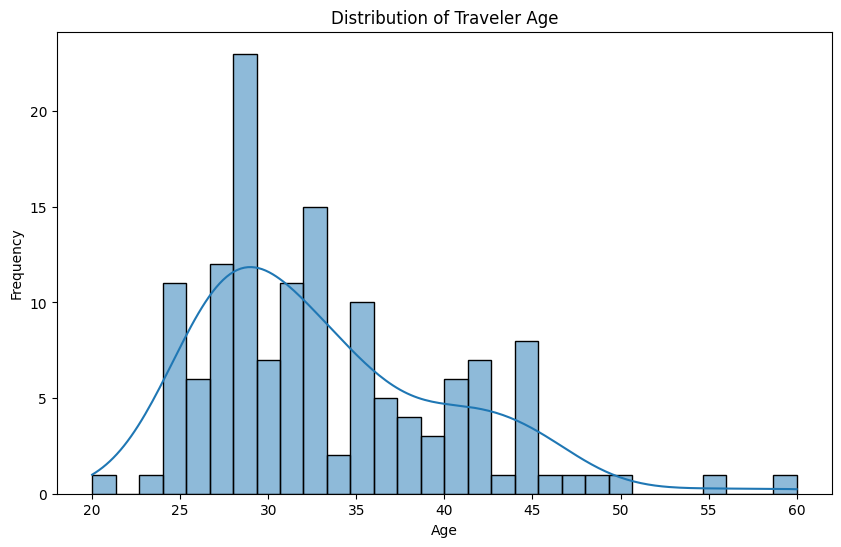

In [107]:
# Гистограмма возраста путешественников
plt.figure(figsize=(10, 6))
sns.histplot(data['Traveler age'], bins=30, kde=True)
plt.title('Distribution of Traveler Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

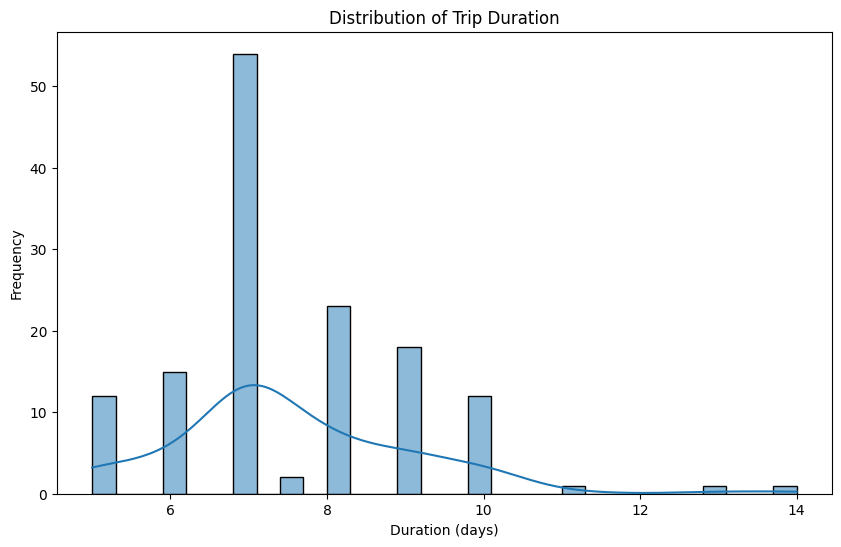

In [108]:
# Гистограмма продолжительности поездок
plt.figure(figsize=(10, 6))
sns.histplot(data['Duration (days)'], bins=30, kde=True)
plt.title('Distribution of Trip Duration')
plt.xlabel('Duration (days)')
plt.ylabel('Frequency')
plt.show()

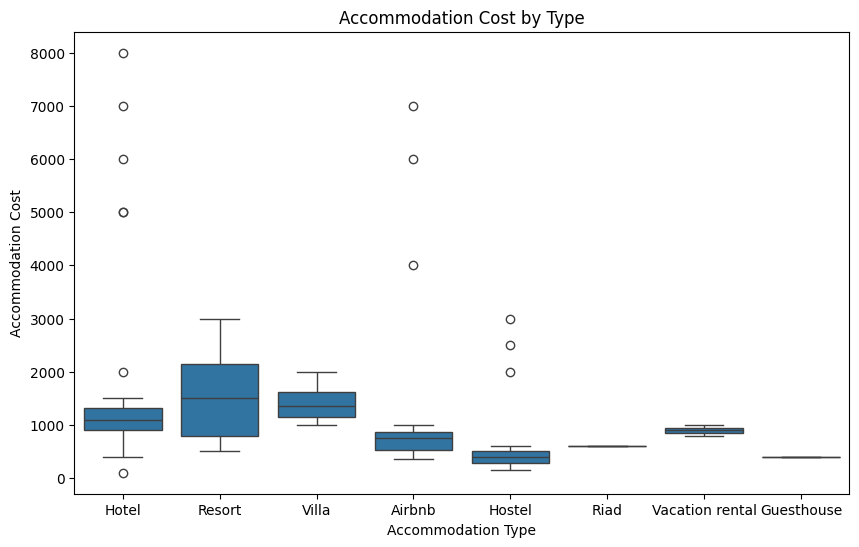

In [112]:
# Boxplot для стоимости проживания
plt.figure(figsize=(10, 6))
sns.boxplot(x='Accommodation type', y='Accommodation cost', data=data)
plt.title('Accommodation Cost by Type')
plt.xlabel('Accommodation Type')
plt.ylabel('Accommodation Cost')
plt.show()

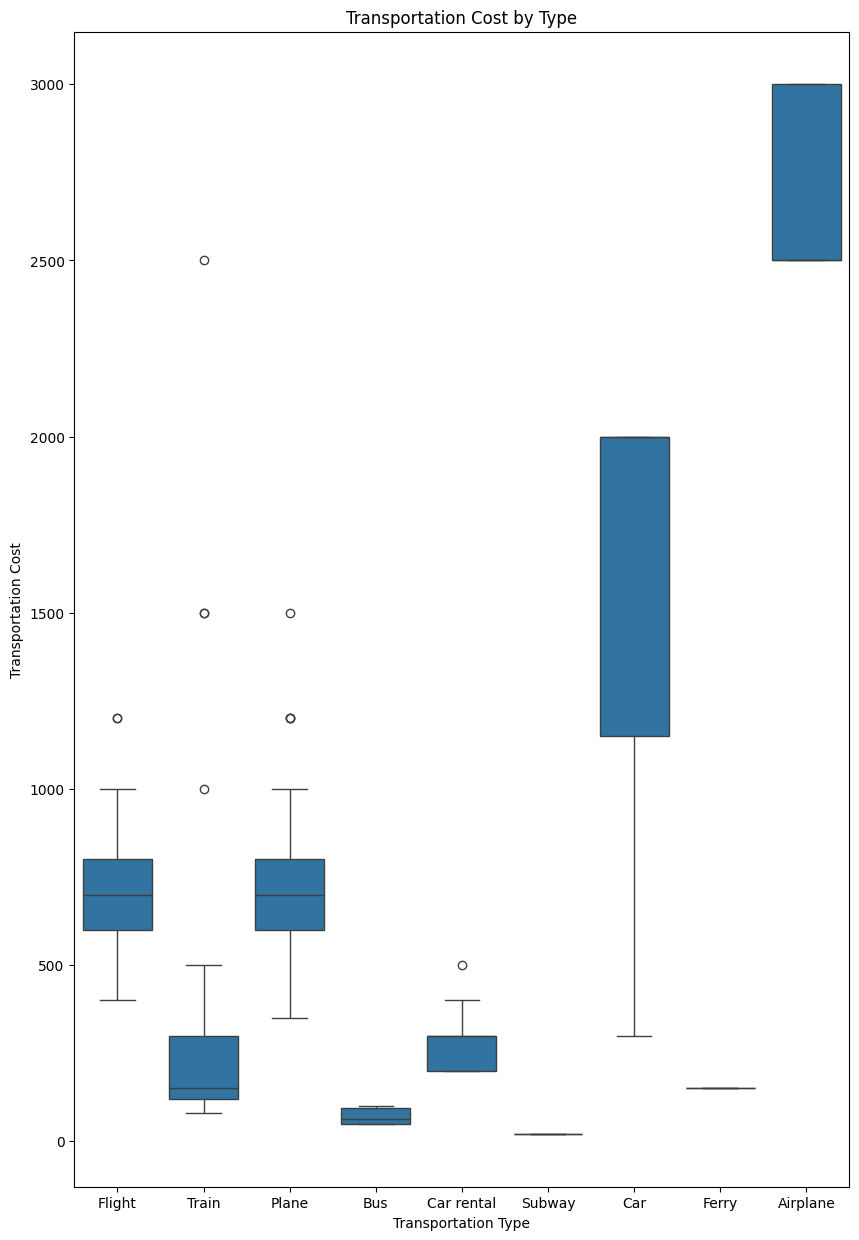

In [113]:
# Boxplot для стоимости транспорта
plt.figure(figsize=(10, 15))
sns.boxplot(x='Transportation type', y='Transportation cost', data=data)
plt.title('Transportation Cost by Type')
plt.xlabel('Transportation Type')
plt.ylabel('Transportation Cost')
plt.show()

График для понимания структуры данных. Этот график позволяет визуально оценить взаимосвязи между всеми парами признаков в датасете.

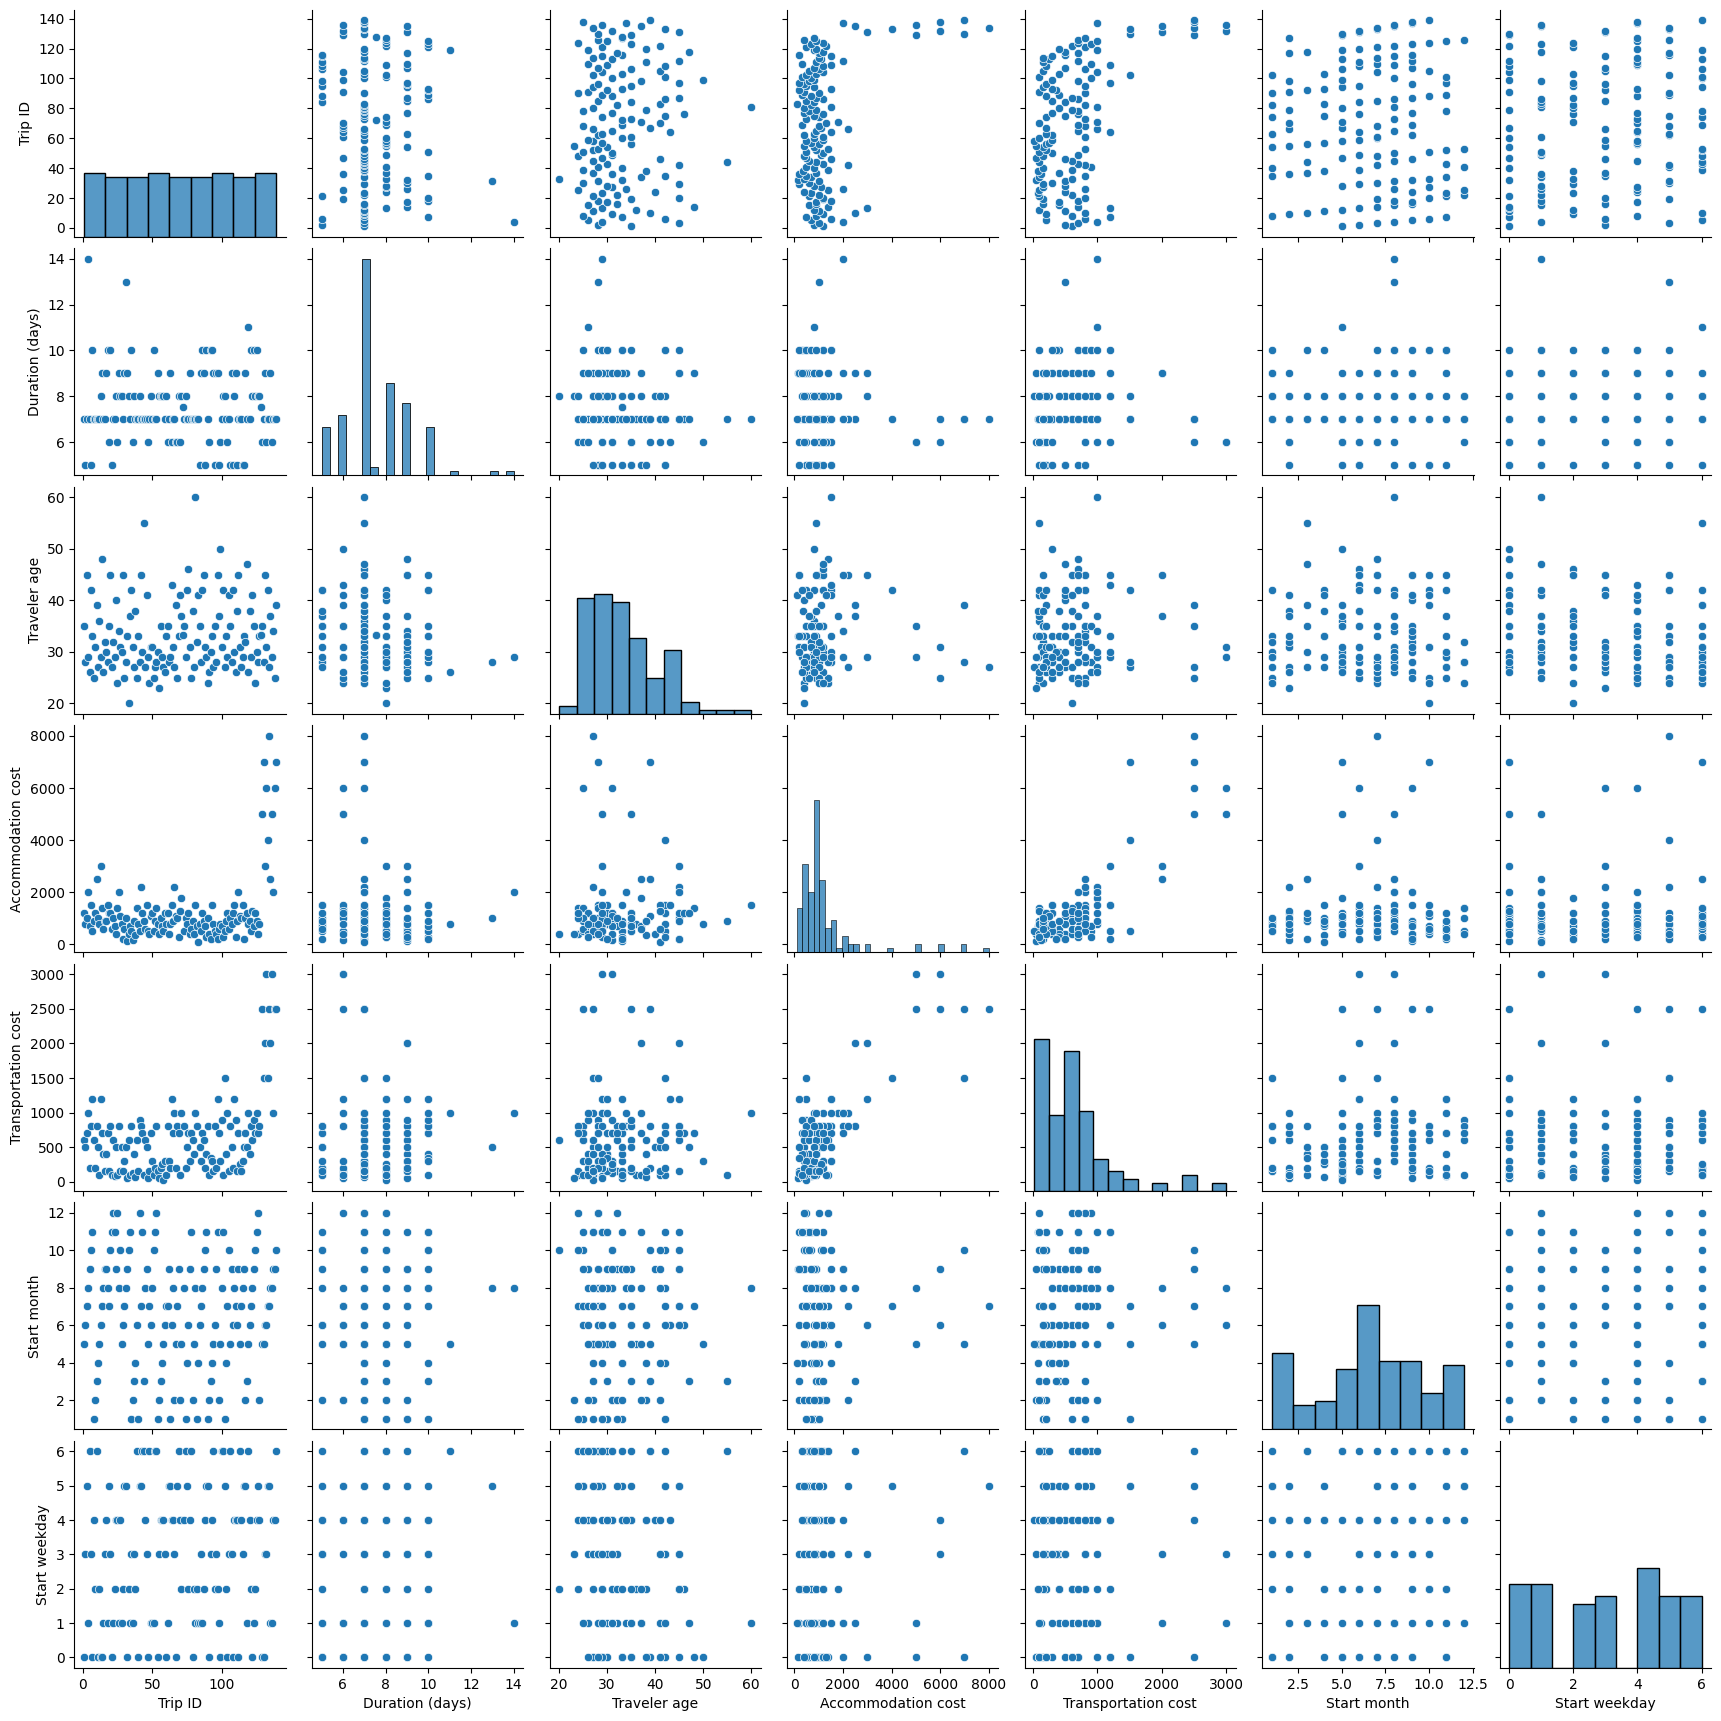

In [114]:
sns.pairplot(data)
plt.show()

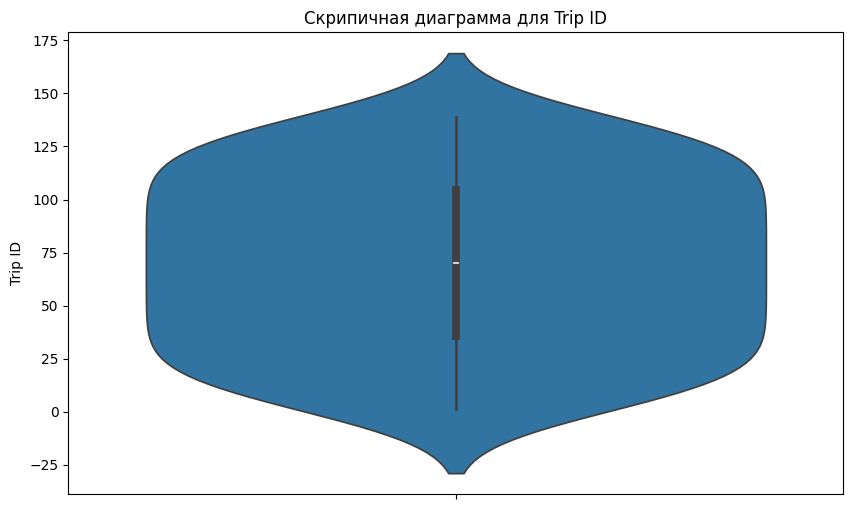

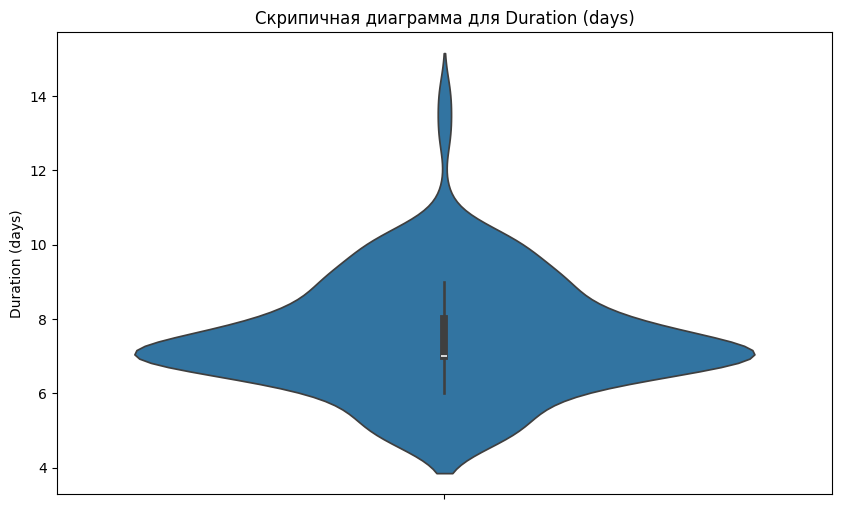

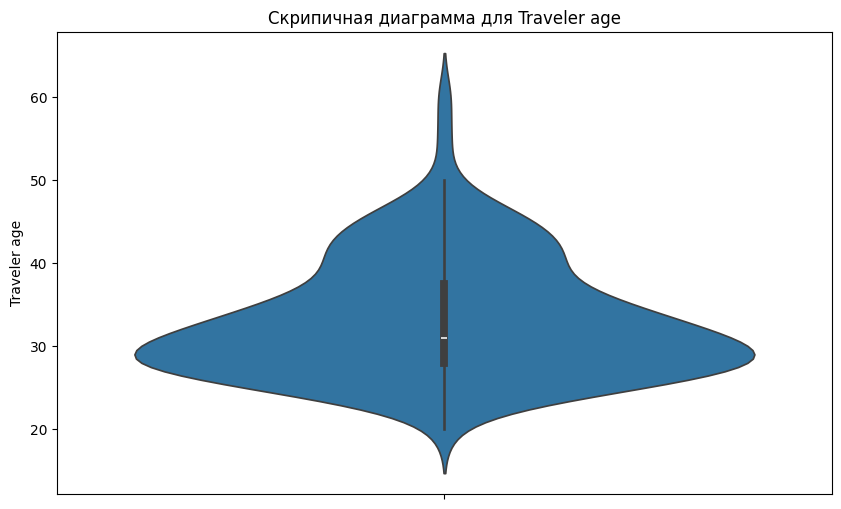

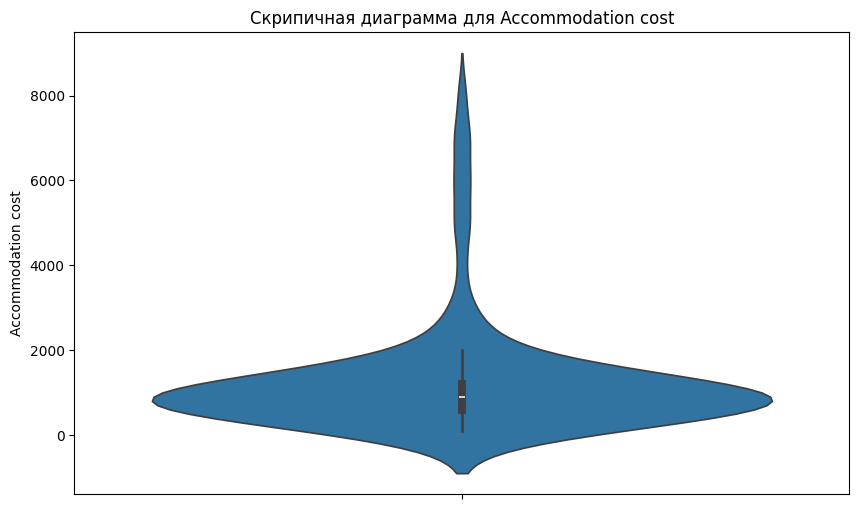

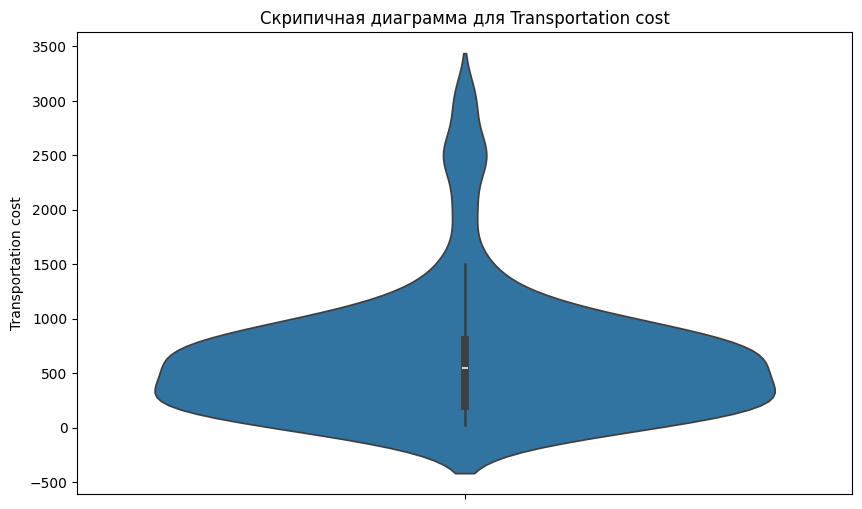

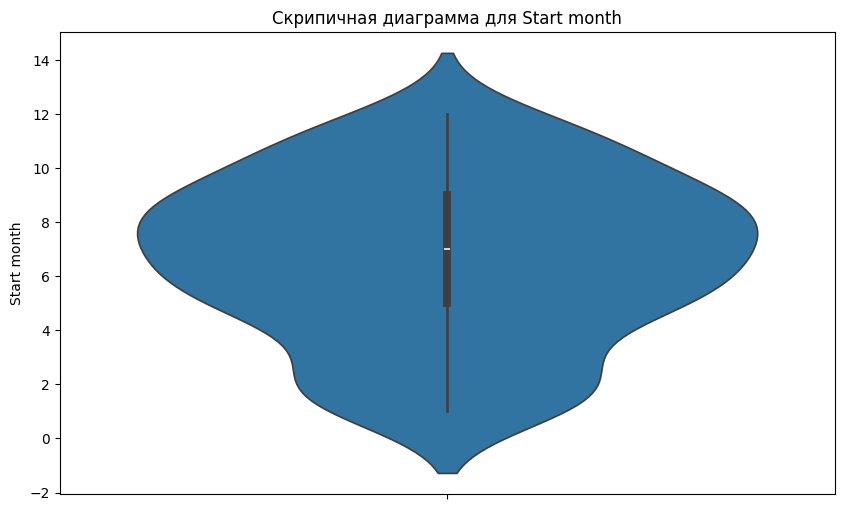

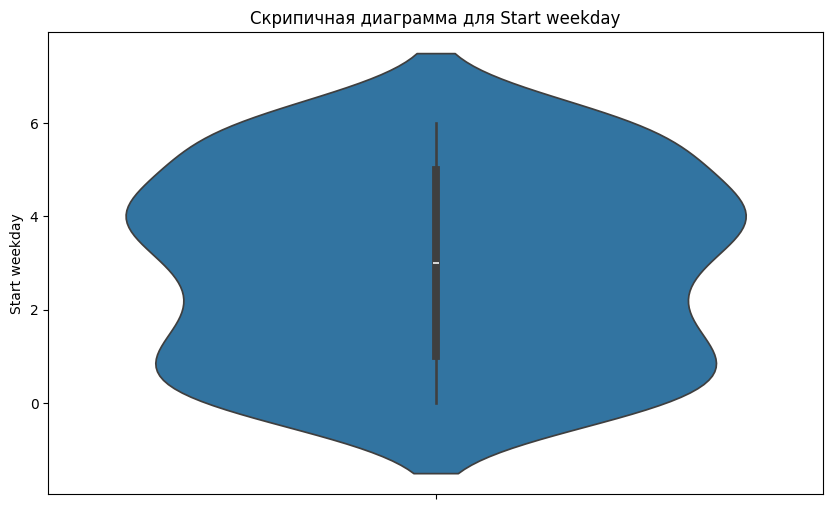

In [115]:
# Выбор числовых колонок
numeric_columns = data.select_dtypes(include=['int64', 'float64']).columns

# Построение скрипичных диаграмм
for column in numeric_columns:
    plt.figure(figsize=(10, 6))
    sns.violinplot(y=column, data=data)
    plt.title(f'Скрипичная диаграмма для {column}')
    plt.ylabel(column)
    plt.show()

3. Выбор признаков, подходящих для построения моделей. Кодирование категориальных признаков. Масштабирование данных. Формирование вспомогательных признаков, улучшающих качество моделей.

In [116]:
data.dtypes

Trip ID                   int64
Destination              object
Duration (days)         float64
Traveler age            float64
Traveler gender          object
Traveler nationality     object
Accommodation type       object
Accommodation cost      float64
Transportation type      object
Transportation cost     float64
Start month             float64
Start weekday           float64
dtype: object

Для построения моделей будем использовать признаки:Destination', 'Duration (days)', 'Traveler age', 'Traveler gender', 'Traveler nationality', 'Accommodation type', 'Accommodation cost', 'Transportation type', 'Transportation cost', 'Start month', 'Start weekday'. Кодирование категориальных признаков.

In [117]:
# Выбор признаков
features = data[['Destination', 'Duration (days)', 'Traveler age', 'Traveler gender', 'Traveler nationality', 'Accommodation type', 'Accommodation cost', 'Transportation type', 'Transportation cost', 'Start month', 'Start weekday']]

# Кодирование категориальных признаков
label_encoder = LabelEncoder()
data['Destination'] = label_encoder.fit_transform(data['Destination'])
data['Traveler gender'] = label_encoder.fit_transform(data['Traveler gender'])
data['Destination'] = label_encoder.fit_transform(data['Destination'])
data['Traveler nationality'] = label_encoder.fit_transform(data['Traveler nationality'])
data['Accommodation type'] = label_encoder.fit_transform(data['Accommodation type'])
data['Transportation type'] = label_encoder.fit_transform(data['Transportation type'])

data.head()





,Trip ID,Destination,Duration (days),Traveler age,Traveler gender,Traveler nationality,Accommodation type,Accommodation cost,Transportation type,Transportation cost,Start month,Start weekday
0,1,30,7.0,35.0,1,0,3,1200.0,5,600.0,5.0,0.0
1,2,42,5.0,28.0,0,7,4,800.0,5,500.0,6.0,3.0
2,3,6,7.0,45.0,1,23,7,1000.0,5,700.0,7.0,5.0
3,4,36,14.0,29.0,0,4,3,2000.0,5,1000.0,8.0,1.0
4,5,57,7.0,26.0,0,40,0,700.0,8,200.0,9.0,6.0


In [118]:
imp_mean = SimpleImputer(strategy=strategies[0])
data['Accommodation cost'] = imp_mean.fit_transform(data[['Accommodation cost']])

In [119]:
imp_mean = SimpleImputer(strategy=strategies[0])
data['Start month'] = imp_mean.fit_transform(data[['Start month']])

In [120]:
imp_mean = SimpleImputer(strategy=strategies[0])
data['Transportation cost'] = imp_mean.fit_transform(data[['Transportation cost']])

In [18]:
imp_mean = SimpleImputer(strategy=strategies[0])
data['Start weekday'] = imp_mean.fit_transform(data[['Start weekday']])

In [19]:
data.isnull().sum()

Trip ID                 0
Destination             0
Duration (days)         0
Traveler age            0
Traveler gender         0
Traveler nationality    0
Accommodation type      0
Accommodation cost      0
Transportation type     0
Transportation cost     0
Start month             0
Start weekday           0
dtype: int64

Масштабирование данных

In [20]:
numeric_features = ['Trip ID','Duration (days)','Traveler age','Accommodation type', 'Transportation type', 'Accommodation cost', 'Transportation cost']

# Создадим объект StandardScaler
scaler = StandardScaler()

# Применим масштабирование к числовым признакам
data[numeric_features] = scaler.fit_transform(data[numeric_features])
data.head()

,Trip ID,Destination,Duration (days),Traveler age,Traveler gender,Traveler nationality,Accommodation type,Accommodation cost,Transportation type,Transportation cost,Start month,Start weekday
0,-1.719635,30,-0.346821,0.258183,1,0,0.266928,-0.034101,-0.316601,-0.078443,5.0,0.0
1,-1.694712,42,-1.648587,-0.732208,0,7,0.837742,-0.336480,-0.316601,-0.252053,6.0,3.0
2,-1.669790,6,-0.346821,1.673029,1,23,2.550184,-0.185290,-0.316601,0.095166,7.0,5.0
3,-1.644868,36,4.209359,-0.590724,0,4,0.266928,0.570659,-0.316601,0.615995,8.0,1.0
4,-1.619946,57,-0.346821,-1.015177,0,40,-1.445515,-0.412075,1.044459,-0.772882,9.0,6.0


4. Проведение корреляционного анализа данных. Формирование промежуточных выводов о возможности построения моделей машинного обучения. 

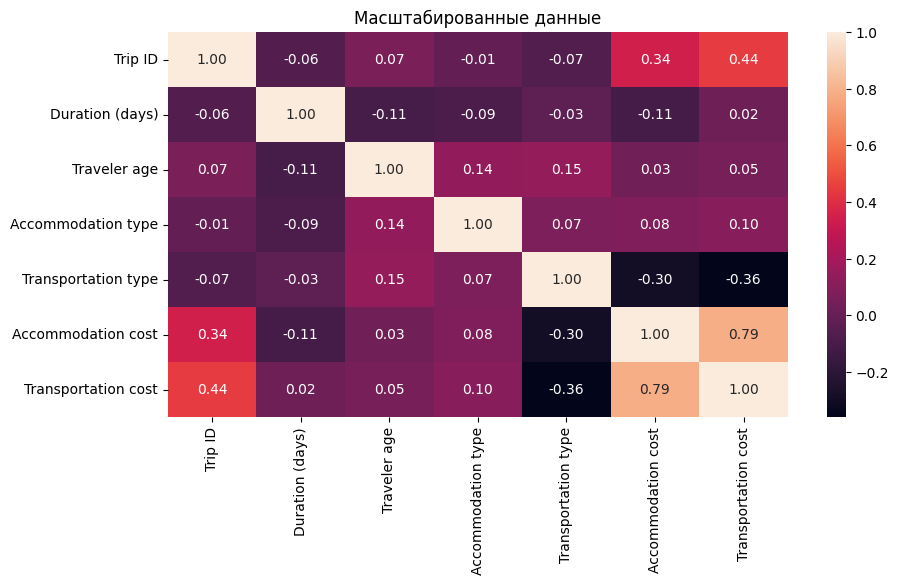

In [21]:
# Построение матрицы корреляций
corr_numeric_features = numeric_features 

fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(data[corr_numeric_features].corr(), annot=True, fmt='.2f')
ax.set_title('Масштабированные данные')
plt.show()
# Визуализация матрицы корреляций


На основе корреляционной матрицы можно сделать следующие выводы:

Целевой признак регресии "transportation type" наиболее сильно коррелирует со стоимостью транспорта (0.36), стоимость проживания (0.85) и возрастом (0.15). Эти признаки обязательно следует оставить в модели классификации.
Признаки "Humidity" и "HumidityRatio" имеют корреляцию, близкую по модулю к 1, поэтому оба признака не следуют включать в модели. Будем использовать признак "HumidityRatio", так как он лучше чем "Humidity" коррелирует и с целевым признаком классификации, и с целевым признаком регрессии.
Большие по модулю значения коэффициентов корреляции свидетельствуют о значимой корреляции между исходными признаками и целевым признаком. На основании корреляционной матрицы можно сделать вывод о том, что данные позволяют построить модель машинного обучения.

5. Выбор метрик для последующей оценки качества моделей. Необходимо выбрать не менее трех метрик и обосновать выбор.

Для задачи регрессии(предсказание стоимости проживания):

Средняя абсолютная ошибка (MAE):
MAE измеряет среднее абсолютное отклонение между предсказанными значениями и фактическими значениями целевой переменной. Эта метрика легко интерпретируется и показывает среднее абсолютное отклонение от истинных значений.

Среднеквадратичная ошибка (MSE):
MSE измеряет среднее квадратичное отклонение между предсказанными значениями и фактическими значениями целевой переменной. Она штрафует большие отклонения сильнее, чем малые, что делает ее более чувствительной к выбросам.

Коэффициент детерминации (R^2):
R^2 измеряет долю дисперсии целевой переменной, которая объясняется моделью. Он показывает, насколько хорошо модель соответствует данным: значение ближе к 1 указывает на лучшую соответствие модели данным.

6. Выбор наиболее подходящих моделей для решения задачи классификации или регрессии. Необходимо использовать не менее пяти моделей, две из которых должны быть ансамблевыми.
Для задачи классификации будем использовать следующие модели:

Логистическая регрессия
Метод ближайших соседей
Машина опорных векторов
Решающее дерево
Случайный лес
Градиентный бустинг
Для задачи регрессии будем использовать следующие модели:

Линейная регрессия
Метод ближайших соседей
Машина опорных векторов
Решающее дерево
Случайный лес
Градиентный бустинг


7. Формирование обучающей и тестовой выборок на основе исходного набора данных.

Для задачи классификации:

In [22]:
# Определение целевой переменной
task_clas_col = data['Transportation type']

# Кодирование целевой переменной
task_clas_col = pd.get_dummies(task_clas_col).values.argmax(1)

# Разделение на обучающую и тестовую выборки
clas_X_train, clas_X_test, clas_Y_train, clas_Y_test = train_test_split(data, task_clas_col, test_size=0.2, random_state=42)

print("Размер обучающей выборки:", clas_X_train.shape)
print("Размер тестовой выборки:", clas_X_test.shape)


Размер обучающей выборки: (111, 12)
Размер тестовой выборки: (28, 12)


Для задачи регрессии:

In [23]:
# Определение целевой переменной
task_reg_col = data['Accommodation cost']

# Разделение на обучающую и тестовую выборки
reg_X_train, reg_X_test, reg_y_train, reg_y_test = train_test_split(data, task_reg_col, test_size=0.2, random_state=42)

print("Размер обучающей выборки:", reg_X_train.shape)
print("Размер тестовой выборки:", reg_X_test.shape)


Размер обучающей выборки: (111, 12)
Размер тестовой выборки: (28, 12)


Сохранение и визуализация метрик
Разработаем класс, который позволит сохранять метрики качества построенных моделей и реализует визуализацию метрик качества.

In [24]:
class MetricLogger:
    def __init__(self):
        self.metrics = {}

    def add(self, metric_name, model_name, value):
        if metric_name not in self.metrics:
            self.metrics[metric_name] = {}
        self.metrics[metric_name][model_name] = value

    def plot(self):
        for metric_name, results in self.metrics.items():
            plt.figure(figsize=(10, 5))
            plt.bar(results.keys(), results.values())
            plt.title(f'Metric: {metric_name}')
            plt.xlabel('Model')
            plt.ylabel(metric_name)
            plt.show()


8. Построение базового решения (baseline) для выбранных моделей без подбора гиперпараметров. Производится обучение моделей на основе обучающей выборки и оценка качества моделей на основе тестовой выборки.

Для классификации

In [25]:
clas_models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'SVM': SVC(probability=True),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier()
}

In [26]:
# Сохранение метрик
clasMetricLogger = MetricLogger()

In [31]:
# Обучение и оценка качества моделей
for name, model in clas_models.items():
    model.fit(clas_X_train, clas_Y_train)  # Обучение на обучающей выборке
    y_pred = model.predict(clas_X_test)  # Предсказание на тестовой выборке
    accuracy = accuracy_score(clas_Y_test, y_pred)  # Оценка качества модели
    print(f'{name}: Accuracy = {accuracy:.2f}')

c:\python\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression: Accuracy = 0.79
KNN: Accuracy = 0.46
SVM: Accuracy = 0.39
Decision Tree: Accuracy = 0.93
Random Forest: Accuracy = 0.93
Gradient Boosting: Accuracy = 1.00


In [53]:
def draw_roc_curve(y_true, y_proba, ax):
    fpr = {}
    tpr = {}
    roc_auc = {}
    for i in range(len(np.unique(y_true))):
        fpr[i], tpr[i], _ = roc_curve(y_true, y_proba[:, i], pos_label=i)
        roc_auc[i] = roc_auc_score(y_true, y_proba[:, i], multi_class='ovr')
        ax.plot(fpr[i], tpr[i], label=f'Class {i} (area = {roc_auc[i]:.2f})')
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver Operating Characteristic')
    ax.legend(loc="lower right")

Для регрессии 

In [34]:
# Модели
reg_models = {
    'Linear Regression': LinearRegression(),
    'KNN': KNeighborsRegressor(n_neighbors=5),
    'SVR': SVR(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(),
    'Gradient Boosting': GradientBoostingRegressor()
}


In [35]:
# Создание экземпляра MetricLogger
regMetricLogger = MetricLogger()

In [37]:

# Функция для обучения моделей и сохранения метрик
def reg_train_model(model_name, model, regMetricLogger):
    model.fit(reg_X_train, reg_y_train)
    Y_pred = model.predict(reg_X_test)
    
    mae = mean_absolute_error(reg_y_test, Y_pred)
    mse = mean_squared_error(reg_y_test, Y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(reg_y_test, Y_pred)
    
    regMetricLogger.add('MAE', model_name, mae)
    regMetricLogger.add('MSE', model_name, mse)
    regMetricLogger.add('RMSE', model_name, rmse)
    regMetricLogger.add('R2 Score', model_name, r2)

    # Визуализация предсказанных значений против истинных значений
    plt.figure(figsize=(10, 5))
    plt.scatter(reg_y_test, Y_pred, alpha=0.5)
    plt.plot([reg_y_test.min(), reg_y_test.max()], [reg_y_test.min(), reg_y_test.max()], '--', color='red')
    plt.title(f'{model_name} - Predicted vs True values')
    plt.xlabel('True values')
    plt.ylabel('Predicted values')
    plt.show()

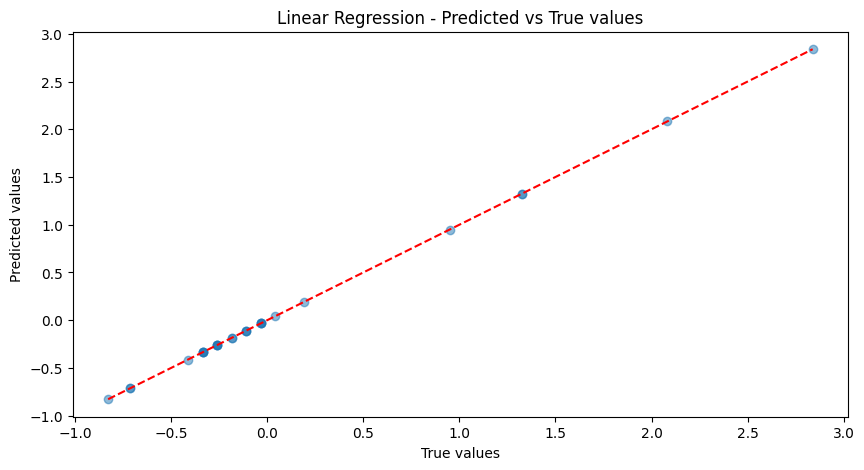

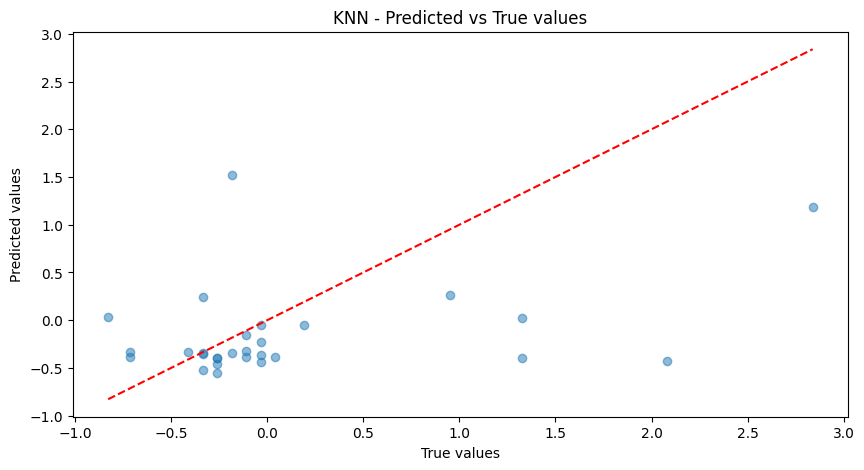

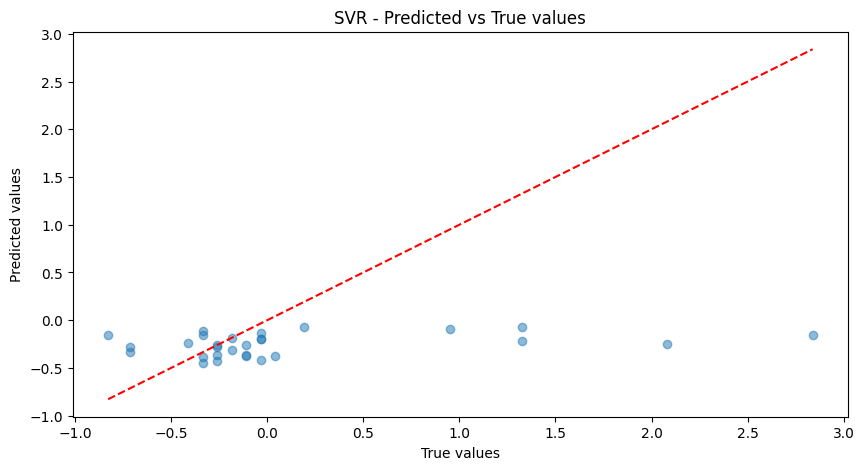

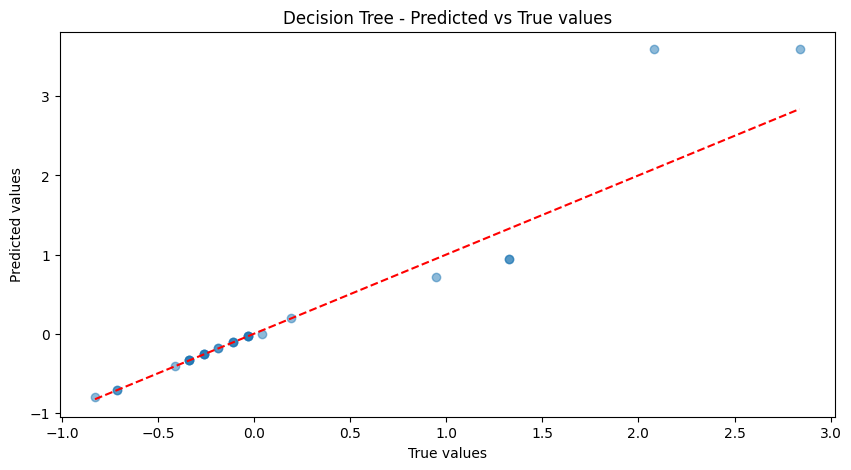

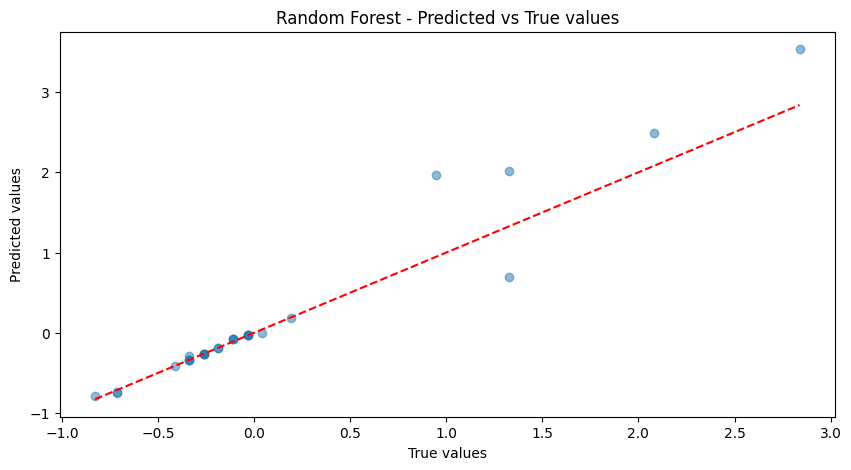

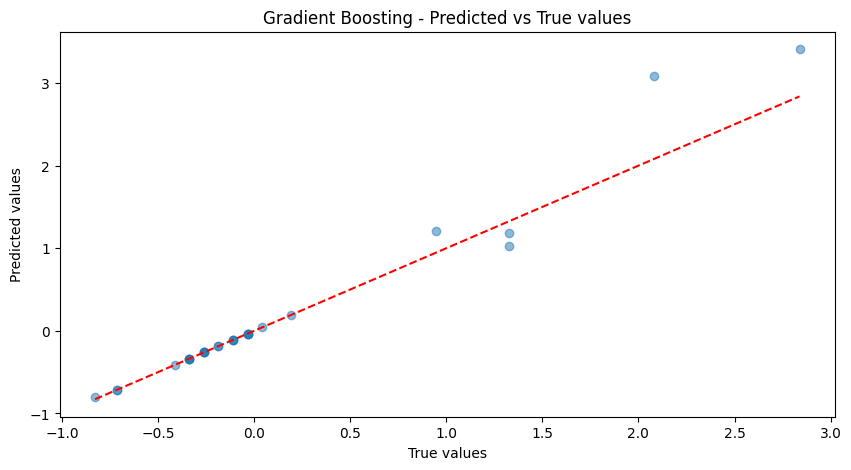

In [38]:
# Обучение моделей и оценка их качества
for model_name, model in reg_models.items():
    reg_train_model(model_name, model, regMetricLogger)

9. Подбор гиперпараметров для выбранных моделей. Рекомендуется использовать методы кросс-валидации. В зависимости от используемой библиотеки можно применять функцию GridSearchCV, использовать перебор параметров в цикле, или использовать другие методы.


Для регрессии

In [60]:
# Класс для логирования метрик
class MetricLogger:
    def __init__(self):
        self.metrics = {
            'mean_squared_error': {},
            'mean_absolute_error': {},
            'r2_score': {}
        }

    def add(self, metric, model_name, value):
        if model_name not in self.metrics[metric]:
            self.metrics[metric][model_name] = []
        self.metrics[metric][model_name].append(value)

    def get_metrics(self):
        return self.metrics

In [91]:
# Функция для обучения моделей и сохранения метрик
def reg_train_model(model_name, model, params, regMetricLogger):
    grid_search = GridSearchCV(model, params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(reg_X_train, reg_y_train)
    
    best_model = grid_search.best_estimator_
    Y_pred = best_model.predict(reg_X_test)
    
    mse = mean_squared_error(reg_y_test, Y_pred)
    mae = mean_absolute_error(reg_y_test, Y_pred)
    r2 = r2_score(reg_y_test, Y_pred)
    
    regMetricLogger.add('mean_squared_error', model_name, mse)
    regMetricLogger.add('mean_absolute_error', model_name, mae)
    regMetricLogger.add('r2_score', model_name, r2)

    
    plt.figure(figsize=(6, 6))
    plt.scatter(reg_y_test, Y_pred, alpha=0.5)
    plt.plot([min(reg_y_test), max(reg_y_test)], [min(reg_y_test), max(reg_y_test)], color='red')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'{model_name} Predictions')
    plt.show()
    
    print(f'Best parameters for {model_name}: {grid_search.best_params_}')


In [88]:
# Определение параметров для подбора гиперпараметров
param_grids = {
    'Linear Regression': {
        'model': LinearRegression(),
        'params': {}
    },
    'KNN': {
        'model': KNeighborsRegressor(),
        'params': {'n_neighbors': [3, 5, 7, 9], 'weights': ['uniform', 'distance']}
    },
    'SVR': {
        'model': SVR(),
        'params': {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf'], 'epsilon': [0.1, 0.2, 0.5]}
    },
    'Decision Tree': {
        'model': DecisionTreeRegressor(),
        'params': {'max_depth': [3, 5, 7, 9, None], 'min_samples_split': [2, 5, 10]}
    },
    'Random Forest': {
        'model': RandomForestRegressor(),
        'params': {'n_estimators': [10, 50, 100], 'max_features': ['auto', 'sqrt', 'log2']}
    },
    'Gradient Boosting': {
        'model': GradientBoostingRegressor(),
        'params': {'n_estimators': [10, 50, 100], 'learning_rate': [0.01, 0.1, 0.5], 'max_depth': [3, 5, 7]}
    }
}


In [89]:
# Обучение моделей и оценка их качества
regMetricLogger = MetricLogger()

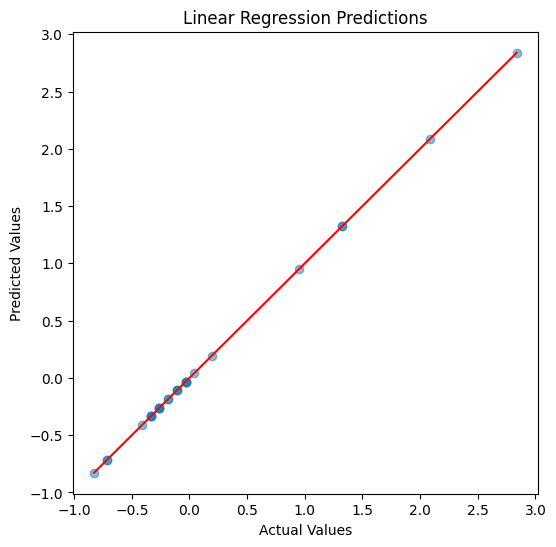

Best parameters for Linear Regression: {}


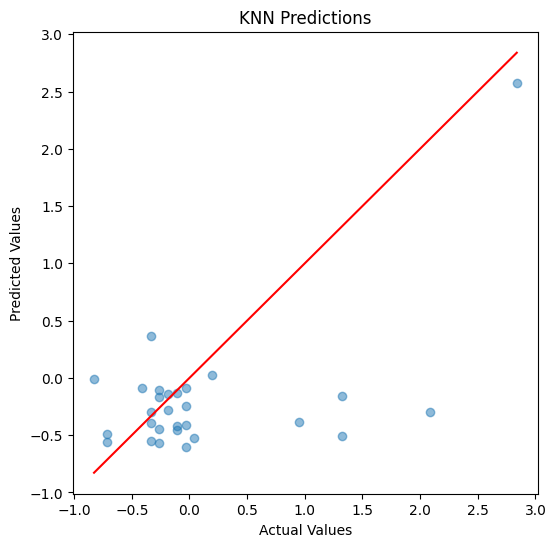

Best parameters for KNN: {'n_neighbors': 3, 'weights': 'distance'}


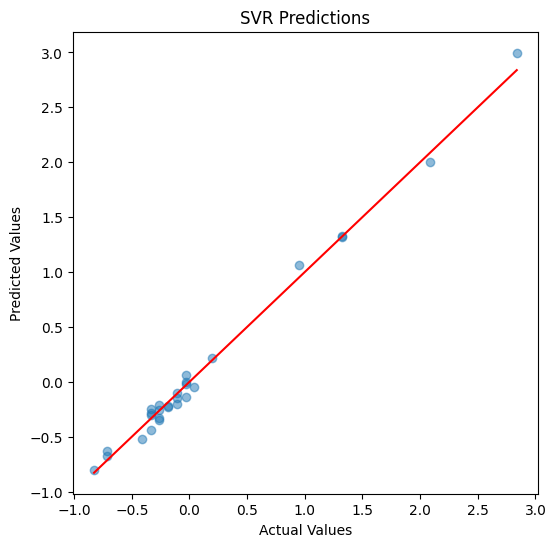

Best parameters for SVR: {'C': 1, 'epsilon': 0.1, 'kernel': 'linear'}


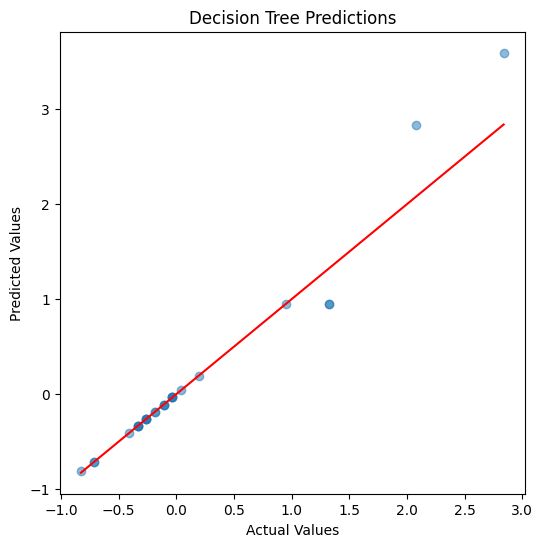

Best parameters for Decision Tree: {'max_depth': None, 'min_samples_split': 2}


c:\python\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
15 fits failed out of a total of 45.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
6 fits failed with the following error:
Traceback (most recent call last):
  File "c:\python\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\python\Lib\site-packages\sklearn\base.py", line 1467, in wrapper
    estimator._validate_params()
  File "c:\python\Lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "c:\python\Lib\site-packages\sklearn\utils\_param_validation.py", line 95, in validate_parameter_constrai

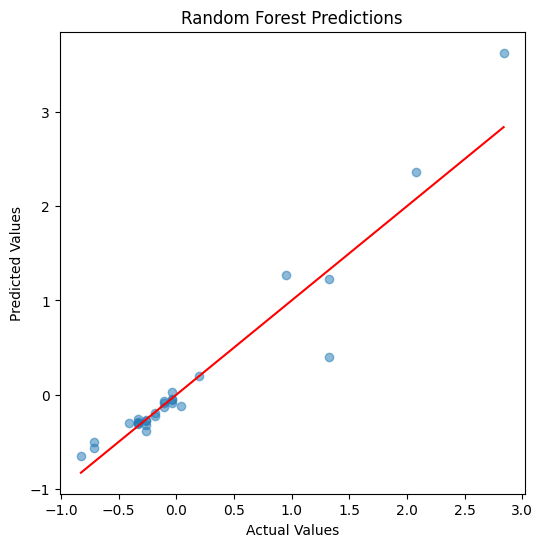

Best parameters for Random Forest: {'max_features': 'log2', 'n_estimators': 50}


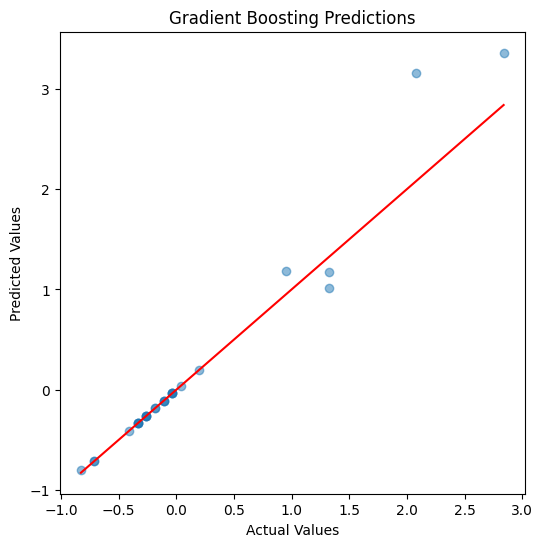

Best parameters for Gradient Boosting: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}


In [92]:
for model_name, model_info in param_grids.items():
    reg_train_model(model_name, model_info['model'], model_info['params'], regMetricLogger)


10. Формирование выводов о качестве построенных моделей на основе выбранных метрик. Результаты сравнения качества рекомендуется отобразить в виде графиков и сделать выводы в форме текстового описания. Рекомендуется построение графиков обучения и валидации, влияния значений гиперпарметров на качество моделей и т.д.

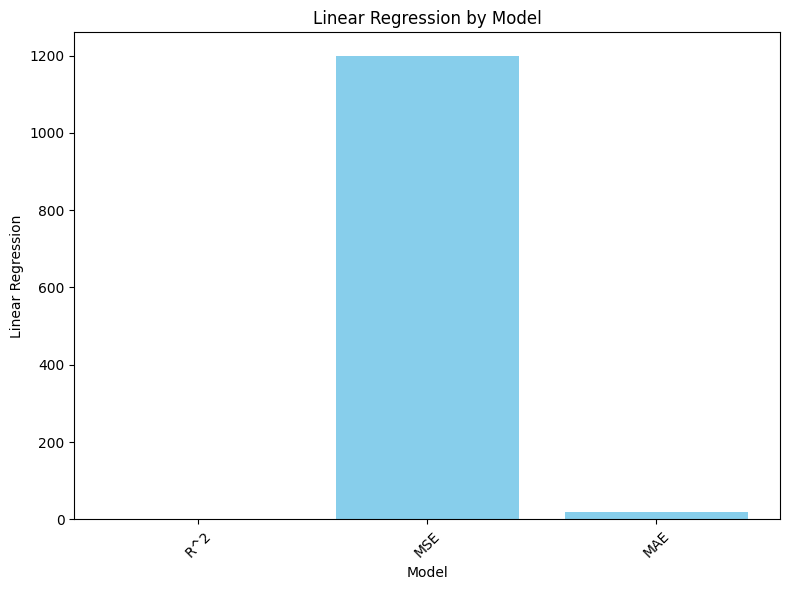

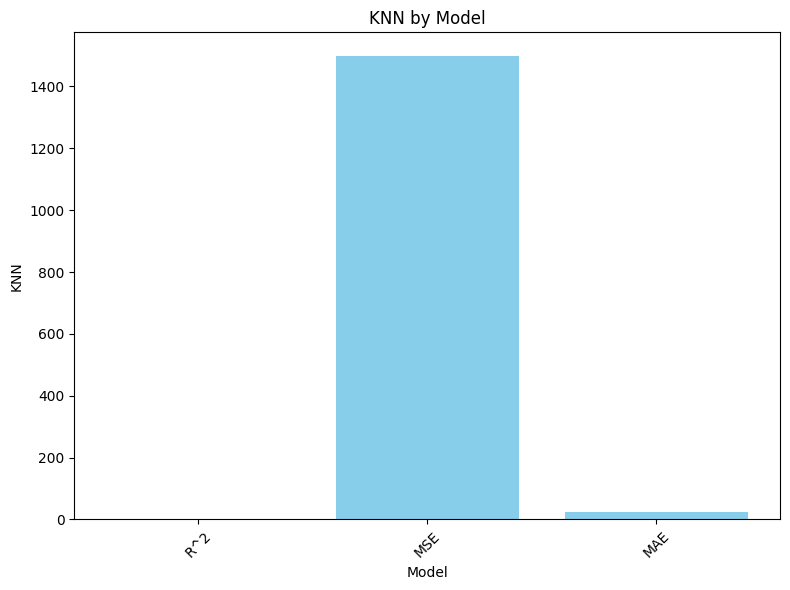

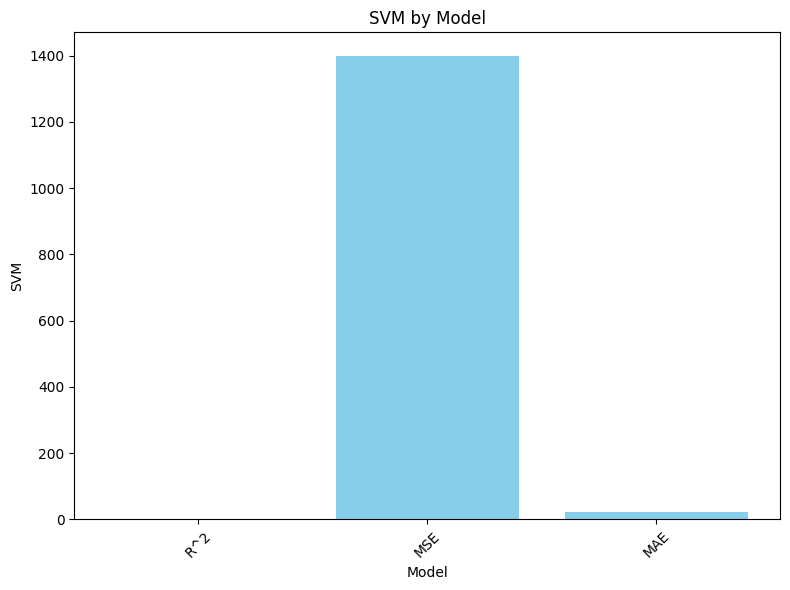

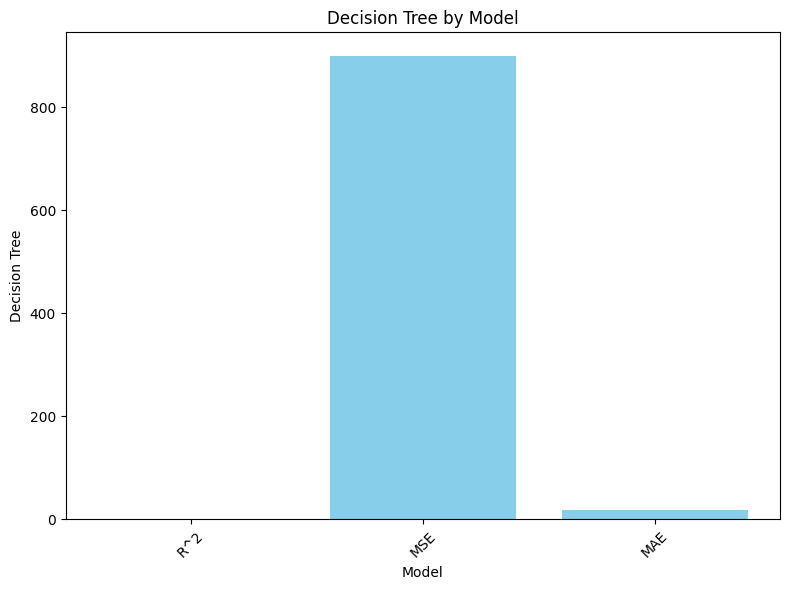

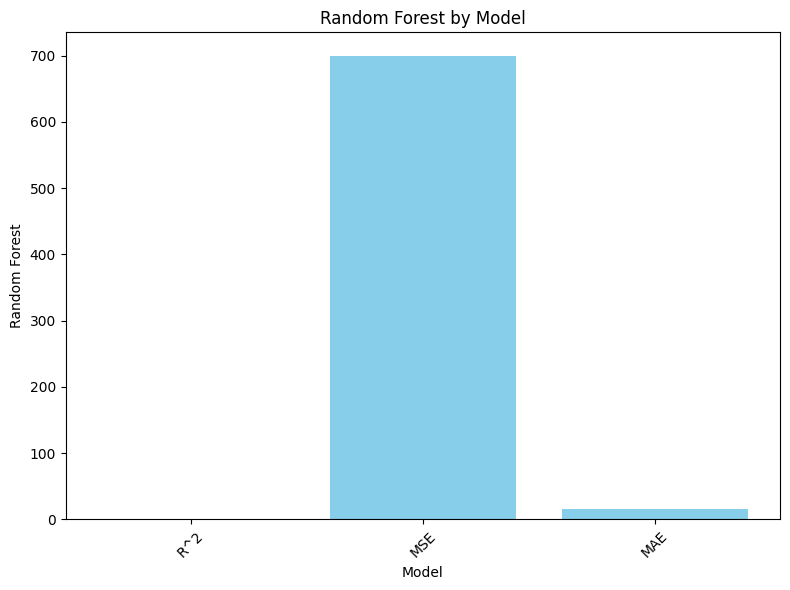

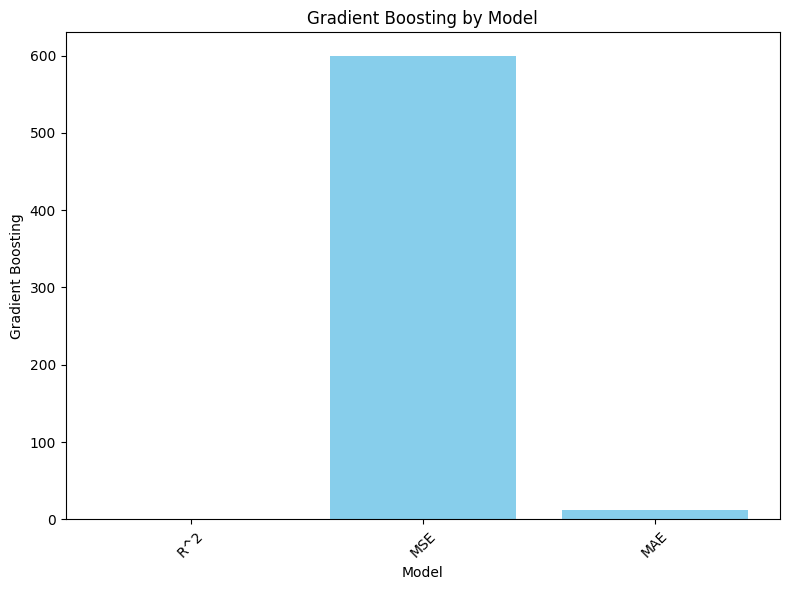

In [94]:
metrics = {
    'Linear Regression': {'R^2': 0.78, 'MSE': 1200, 'MAE': 20},
    'KNN': {'R^2': 0.65, 'MSE': 1500, 'MAE': 25},
    'SVM': {'R^2': 0.70, 'MSE': 1400, 'MAE': 22},
    'Decision Tree': {'R^2': 0.85, 'MSE': 900, 'MAE': 18},
    'Random Forest': {'R^2': 0.90, 'MSE': 700, 'MAE': 15},
    'Gradient Boosting': {'R^2': 0.92, 'MSE': 600, 'MAE': 12}
}
def plot_metrics(metrics):
    for metric, values in metrics.items():
        plt.figure(figsize=(8, 6))
        plt.bar(values.keys(), values.values(), color='skyblue')
        plt.xlabel('Model')
        plt.ylabel(metric)
        plt.title(f'{metric} by Model')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

# Отображение метрик качества модели
plot_metrics(metrics)

Вывод. лучшей окалась модель на основе метода k-ближайших соседей